In [1]:
!pip install -q "transformers>=4.46.0" "datasets>=2.19.0" "peft>=0.13.0" "bitsandbytes>=0.44.0" accelerate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 39.5 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login
login("")

In [3]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)
from peft import LoraConfig, get_peft_model, AutoPeftModelForCausalLM
from sklearn.metrics import classification_report
import re
import os
import pandas as pd
from torch.nn.utils.rnn import pad_sequence


In [4]:
# Imports and global settings

import random
import numpy as np
import torch

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from sklearn.metrics import classification_report

# Model ID required by the assignment
MODEL_ID = "meta-llama/Llama-3.2-1B-Instruct"

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [5]:

# Specific HF commit where parquet files exist
from datasets import load_dataset
COMMIT_ID = "6a6693e606d879b01e4cd97bd06181e6a932db08"

base_path = (
    f"hf://datasets/cardiffnlp/tweet_sentiment_multilingual@{COMMIT_ID}/english"
)

data_files = {
    "train": f"{base_path}/tweet_sentiment_multilingual-train.parquet",
    "validation": f"{base_path}/tweet_sentiment_multilingual-validation.parquet",
    "test": f"{base_path}/tweet_sentiment_multilingual-test.parquet",
}

dataset = load_dataset("parquet", data_files=data_files)

train_ds = dataset["train"]
test_ds = dataset["test"]
val_ds = dataset["validation"]

len(train_ds), len(test_ds), len(val_ds)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)eet_sentiment_multilingual-train.parquet:   0%|          | 0.00/155k [00:00<?, ?B/s]

(…)entiment_multilingual-validation.parquet:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

(…)weet_sentiment_multilingual-test.parquet:   0%|          | 0.00/64.8k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

(1839, 870, 324)

In [6]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA A100-SXM4-80GB')

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype="auto",
    use_auth_token=True
)

label2id = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

def interpret_sentiment(raw_output):
    text = raw_output.lower().strip()
    words = text.replace(":", " ").replace("\n", " ").split()
    for w in words:
        if w in ["positive", "negative", "neutral"]:
            return w
    if text in ["positive", "negative", "neutral"]:
        return text
    return "neutral"

def evaluate_predictions(predict_fn, data_split):
    split = dataset[data_split]
    gold_labels = []
    pred_labels = []
    texts = []

    for idx, row in enumerate(split):
        if (idx + 1) % 60 == 0:
            print(f"Running inference on {idx+1}/{len(split)} items...")

        text = row["text"]
        gold_labels.append(row["label"])
        texts.append(text)

        pred = predict_fn(text)
        pred_labels.append(label2id[pred])

    print(classification_report(
        gold_labels,
        pred_labels,
        target_names=["negative", "neutral", "positive"]
    ))

    return texts, gold_labels, pred_labels

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [8]:
#zero shot predection test, small test
def predict_zero_shot(text):
    prompt = f'Is this text negative, neutral, or positive? Answer in one word: "{text}"'

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=5,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
    )

    out_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    sentiment = interpret_sentiment(out_text)
    return sentiment


In [9]:
texts, gold, pred = evaluate_predictions(predict_zero_shot, "test")


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running inference on 60/870 items...
Running inference on 120/870 items...
Running inference on 180/870 items...
Running inference on 240/870 items...
Running inference on 300/870 items...
Running inference on 360/870 items...
Running inference on 420/870 items...
Running inference on 480/870 items...
Running inference on 540/870 items...
Running inference on 600/870 items...
Running inference on 660/870 items...
Running inference on 720/870 items...
Running inference on 780/870 items...
Running inference on 840/870 items...
              precision    recall  f1-score   support

    negative       0.53      0.09      0.15       290
     neutral       0.33      0.93      0.49       290
    positive       0.80      0.01      0.03       290

    accuracy                           0.34       870
   macro avg       0.55      0.34      0.22       870
weighted avg       0.55      0.34      0.22       870



In [10]:
#QLORA
!pip install -q "transformers>=4.46.0" "datasets>=2.19.0" "peft>=0.13.0" "bitsandbytes>=0.44.0" accelerate


In [11]:
from transformers import (
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)
from peft import LoraConfig, get_peft_model, AutoPeftModelForCausalLM

# Map from integer label -> string, using your dataset's encoding
id2label = {
    0: "negative",
    1: "neutral",
    2: "positive",
}

# QLoRA model loader: 4-bit NF4 + LoRA adapters
def get_qlora_model():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        device_map="auto",
        quantization_config=bnb_config,
        use_auth_token=True,
    )

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )

    model = get_peft_model(base_model, lora_config)
    print("QLoRA model loaded on:", model.device)
    return model


Format Training Data for QLoRA (Template + Label Masking)

onverts  dataset into the same supervised format
user prompt

assistant answer (= sentiment label)

masks user tokens with -100

keeps only assistant label tokens as trainable

In [12]:
BASE_PROMPT = 'Evaluate for sentiment (neutral, positive, negative): '

def format_for_training(batch):
    texts = batch["text"]
    labels = batch["label"]          # integers: 0,1,2
    label_words = [id2label[l] for l in labels]

    # Build conversation structure
    prompts = [
        [
            {"role": "user", "content": BASE_PROMPT + f'"{t}"'},
            {"role": "assistant", "content": lw},
        ]
        for t, lw in zip(texts, label_words)
    ]

    # 1. full conversation (user + assistant)
    conv_texts = [
        tokenizer.apply_chat_template(p, tokenize=False)
        for p in prompts
    ]

    encoded = tokenizer(
        conv_texts,
        padding=False,
        truncation=True,
        return_attention_mask=True,
    )

    # 2. build user-only prompts to figure out masking length
    user_prompts = [
        [{"role": "user", "content": BASE_PROMPT + f'"{t}"'}]
        for t in texts
    ]
    user_conv = [
        tokenizer.apply_chat_template(p, tokenize=False)
        for p in user_prompts
    ]
    user_ids = tokenizer(user_conv)["input_ids"]
    user_lengths = [len(ids) for ids in user_ids]

    # 3. Create label masks
    labels_out = []
    for input_ids, ul in zip(encoded["input_ids"], user_lengths):
        y = input_ids.copy()
        y[:ul] = [-100] * ul  # mask everything before the assistant part
        labels_out.append(y)

    encoded["labels"] = labels_out
    return encoded


Tokenize Dataset + Create Data Collator

tokenizes the train/validation sets for QLoRA

removes unused columns

creates a collator that pads correctly

gets ready for the Trainer

In [13]:
# Remove text + label columns after formatting
columns_to_remove = ["text", "label"]

tokenized_dataset = dataset.map(
    format_for_training,
    batched=True,
    remove_columns=columns_to_remove,
)

# Collator that handles padding and -100 labels
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=None,              # model is added later to Trainer
    padding=True,
    label_pad_token_id=-100,
)

tokenized_dataset


Map:   0%|          | 0/1839 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 324
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 870
    })
})

In [14]:
qlora_results = {}


In [15]:
def train_qlora(num_epochs: int, run_name: str):
    """
    Train a QLoRA model for num_epochs and save it to ./qlora-{run_name}-ep{num_epochs}
    """
    output_dir = f"./qlora-{run_name}-ep{num_epochs}"
    print(f"\n➡️ Training QLoRA for {num_epochs} epoch(s) → saving to {output_dir}")

    # Load QLoRA model (NF4 quant + LoRA adapters)
    model = get_qlora_model()

    # Minimal, v5-compatible TrainingArguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        weight_decay=0.01,
        learning_rate=2e-4,
        logging_steps=50,
        report_to="none",
        bf16=True,
        save_total_limit=2,      # safe to keep
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],  # Will not auto-eval
        data_collator=data_collator,
    )

    trainer.train()

    # Save LoRA adapters and tokenizer
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"Finished training {num_epochs} epoch(s)")
    print(f"Model saved at: {output_dir}")





In [16]:
EPOCHS_TO_RUN = [1, 2, 3, 5, 7]

for ep in EPOCHS_TO_RUN:
    train_qlora(ep, run_name="sentiment")






➡️ Training QLoRA for 1 epoch(s) → saving to ./qlora-sentiment-ep1


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


QLoRA model loaded on: cuda:0


Step,Training Loss
50,0.228500
100,0.123400
150,0.113700
200,0.116500


🎉 Finished training 1 epoch(s)
📁 Model saved at: ./qlora-sentiment-ep1

➡️ Training QLoRA for 2 epoch(s) → saving to ./qlora-sentiment-ep2


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


QLoRA model loaded on: cuda:0


Step,Training Loss
50,0.229600
100,0.125600
150,0.120000
200,0.130000
250,0.102000
300,0.090300
350,0.077100
400,0.073200
450,0.075900


🎉 Finished training 2 epoch(s)
📁 Model saved at: ./qlora-sentiment-ep2

➡️ Training QLoRA for 3 epoch(s) → saving to ./qlora-sentiment-ep3


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


QLoRA model loaded on: cuda:0


Step,Training Loss
50,0.229600
100,0.124500
150,0.119300
200,0.133700
250,0.104800
300,0.092000
350,0.079100
400,0.075100
450,0.078000
500,0.063500


🎉 Finished training 3 epoch(s)
📁 Model saved at: ./qlora-sentiment-ep3

➡️ Training QLoRA for 5 epoch(s) → saving to ./qlora-sentiment-ep5


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


QLoRA model loaded on: cuda:0


Step,Training Loss
50,0.227700
100,0.127600
150,0.122000
200,0.134800
250,0.105100
300,0.093200
350,0.079500
400,0.076400
450,0.079000
500,0.063800


🎉 Finished training 5 epoch(s)
📁 Model saved at: ./qlora-sentiment-ep5

➡️ Training QLoRA for 7 epoch(s) → saving to ./qlora-sentiment-ep7


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


QLoRA model loaded on: cuda:0


Step,Training Loss
50,0.230900
100,0.126300
150,0.122200
200,0.135700
250,0.104600
300,0.092900
350,0.080200
400,0.078200
450,0.083200
500,0.064300


🎉 Finished training 7 epoch(s)
📁 Model saved at: ./qlora-sentiment-ep7


In [17]:
def make_qlora_predict_fn(model_dir: str):
    """
    Load a QLoRA model from model_dir and return a predict(text) function
    that outputs one of: 'negative', 'neutral', 'positive'.

    Uses the SAME chat template + BASE_PROMPT that we used during training.
    """
    print(f"Loading QLoRA model from: {model_dir}")

    qlora_model = AutoPeftModelForCausalLM.from_pretrained(
        model_dir,
        dtype=torch.bfloat16,
        device_map="auto",
    )

    # Note: fix_mistral_regex=True removes that warning. Safe for LLaMA too.
    qlora_tokenizer = AutoTokenizer.from_pretrained(
        model_dir,
        fix_mistral_regex=True,
    )
    qlora_tokenizer.pad_token = qlora_tokenizer.eos_token
    qlora_tokenizer.padding_side = "left"

    def predict(text: str) -> str:
        # Build the same “user” message we used in training
        conversation = [
            {"role": "user", "content": BASE_PROMPT + f'"{text}"'}
        ]

        # Apply the chat template and add the generation prompt
        prompt_str = qlora_tokenizer.apply_chat_template(
            conversation,
            tokenize=False,
            add_generation_prompt=True,
        )

        inputs = qlora_tokenizer(
            prompt_str,
            return_tensors="pt",
            padding=False,
            truncation=True,
        ).to(qlora_model.device)

        with torch.no_grad():
            outputs = qlora_model.generate(
                **inputs,
                max_new_tokens=10,
                do_sample=False,
                pad_token_id=qlora_tokenizer.eos_token_id,
            )

        # Slice off the prompt tokens and decode only the new ones
        new_tokens = outputs[:, inputs["input_ids"].shape[1]:]
        out_text = qlora_tokenizer.decode(
            new_tokens[0],
            skip_special_tokens=True,
        )

        return interpret_sentiment(out_text)

    return predict



In [18]:
qlora_model_dirs = [
    "./qlora-sentiment-ep1",
    "./qlora-sentiment-ep2",
    "./qlora-sentiment-ep3",
    "./qlora-sentiment-ep5",
    "./qlora-sentiment-ep7",
]

for model_dir in qlora_model_dirs:
    if not os.path.exists(model_dir):
        print(f"Model directory not found: {model_dir}")
        continue

    print("\n" + "=" * 80)
    print(f"******** Evaluating QLoRA model: {model_dir}")
    predict_fn = make_qlora_predict_fn(model_dir)
    texts_q, gold_q, pred_q = evaluate_predictions(predict_fn, "test")



******** Evaluating QLoRA model: ./qlora-sentiment-ep1
Loading QLoRA model from: ./qlora-sentiment-ep1


The tokenizer you are loading from './qlora-sentiment-ep1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Running inference on 60/870 items...
Running inference on 120/870 items...
Running inference on 180/870 items...
Running inference on 240/870 items...
Running inference on 300/870 items...
Running inference on 360/870 items...
Running inference on 420/870 items...
Running inference on 480/870 items...
Running inference on 540/870 items...
Running inference on 600/870 items...
Running inference on 660/870 items...
Running inference on 720/870 items...
Running inference on 780/870 items...
Running inference on 840/870 items...
              precision    recall  f1-score   support

    negative       0.54      0.98      0.70       290
     neutral       0.72      0.20      0.32       290
    positive       0.83      0.75      0.79       290

    accuracy                           0.64       870
   macro avg       0.70      0.64      0.60       870
weighted avg       0.70      0.64      0.60       870


******** Evaluating QLoRA model: ./qlora-sentiment-ep2
Loading QLoRA model from: ./qlor

The tokenizer you are loading from './qlora-sentiment-ep2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Running inference on 60/870 items...
Running inference on 120/870 items...
Running inference on 180/870 items...
Running inference on 240/870 items...
Running inference on 300/870 items...
Running inference on 360/870 items...
Running inference on 420/870 items...
Running inference on 480/870 items...
Running inference on 540/870 items...
Running inference on 600/870 items...
Running inference on 660/870 items...
Running inference on 720/870 items...
Running inference on 780/870 items...
Running inference on 840/870 items...
              precision    recall  f1-score   support

    negative       0.65      0.94      0.77       290
     neutral       0.65      0.46      0.54       290
    positive       0.84      0.72      0.77       290

    accuracy                           0.70       870
   macro avg       0.71      0.70      0.69       870
weighted avg       0.71      0.70      0.69       870


******** Evaluating QLoRA model: ./qlora-sentiment-ep3
Loading QLoRA model from: ./qlor

The tokenizer you are loading from './qlora-sentiment-ep3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Running inference on 60/870 items...
Running inference on 120/870 items...
Running inference on 180/870 items...
Running inference on 240/870 items...
Running inference on 300/870 items...
Running inference on 360/870 items...
Running inference on 420/870 items...
Running inference on 480/870 items...
Running inference on 540/870 items...
Running inference on 600/870 items...
Running inference on 660/870 items...
Running inference on 720/870 items...
Running inference on 780/870 items...
Running inference on 840/870 items...
              precision    recall  f1-score   support

    negative       0.65      0.92      0.76       290
     neutral       0.64      0.49      0.55       290
    positive       0.86      0.70      0.77       290

    accuracy                           0.70       870
   macro avg       0.71      0.70      0.69       870
weighted avg       0.71      0.70      0.69       870


******** Evaluating QLoRA model: ./qlora-sentiment-ep5
Loading QLoRA model from: ./qlor

The tokenizer you are loading from './qlora-sentiment-ep5' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Running inference on 60/870 items...
Running inference on 120/870 items...
Running inference on 180/870 items...
Running inference on 240/870 items...
Running inference on 300/870 items...
Running inference on 360/870 items...
Running inference on 420/870 items...
Running inference on 480/870 items...
Running inference on 540/870 items...
Running inference on 600/870 items...
Running inference on 660/870 items...
Running inference on 720/870 items...
Running inference on 780/870 items...
Running inference on 840/870 items...
              precision    recall  f1-score   support

    negative       0.69      0.87      0.77       290
     neutral       0.59      0.55      0.57       290
    positive       0.85      0.69      0.76       290

    accuracy                           0.70       870
   macro avg       0.71      0.70      0.70       870
weighted avg       0.71      0.70      0.70       870


******** Evaluating QLoRA model: ./qlora-sentiment-ep7
Loading QLoRA model from: ./qlor

The tokenizer you are loading from './qlora-sentiment-ep7' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Running inference on 60/870 items...
Running inference on 120/870 items...
Running inference on 180/870 items...
Running inference on 240/870 items...
Running inference on 300/870 items...
Running inference on 360/870 items...
Running inference on 420/870 items...
Running inference on 480/870 items...
Running inference on 540/870 items...
Running inference on 600/870 items...
Running inference on 660/870 items...
Running inference on 720/870 items...
Running inference on 780/870 items...
Running inference on 840/870 items...
              precision    recall  f1-score   support

    negative       0.70      0.87      0.78       290
     neutral       0.61      0.59      0.60       290
    positive       0.85      0.68      0.75       290

    accuracy                           0.71       870
   macro avg       0.72      0.71      0.71       870
weighted avg       0.72      0.71      0.71       870



Block 9: Side-by-side accuracy + F1 comparison chart

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

def evaluate_model_predictions(predict_fn):
    """
    Runs prediction on the TEST set and returns:
    - gold_labels (list[int])
    - pred_labels (list[int])
    - df (pandas DataFrame containing text, gold, predicted)
    """
    texts = []
    gold = []
    preds = []

    test_split = dataset["test"]

    for i, row in enumerate(test_split):
        text = row["text"]
        label = row["label"]

        pred_label_str = predict_fn(text)
        pred_label = label2id[pred_label_str]

        texts.append(text)
        gold.append(label)
        preds.append(pred_label)

    df = pd.DataFrame({
        "text": texts,
        "gold": gold,
        "pred": preds,
        "gold_label": [id2label[g] for g in gold],
        "pred_label": [id2label[p] for p in preds]
    })

    return gold, preds, df


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(gold, preds, title="Confusion Matrix"):
    cm = confusion_matrix(gold, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=id2label,
                yticklabels=id2label)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


In [22]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

def load_qlora_model(model_path):
    """
    Loads a saved QLoRA model and its tokenizer from disk.
    Works for directories like ./qlora-sentiment-ep1
    """
    print(f"🔄 Loading QLoRA model from: {model_path}")

    # Load merged LoRA+base model (AutoPeft handles adapters automatically)
    model = AutoPeftModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype="auto",
        device_map="auto",
    )

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_path,
        use_fast=True,
        fix_mistral_regex=True
    )

    print("Model and tokenizer loaded.")
    return model, tokenizer


In [23]:
def make_predict_qlora(model_path):
    """
    Loads a QLoRA model + tokenizer safely even if load_qlora_model()
    only returns a model.
    """

    loaded = load_qlora_model(model_path)

    # Case 1: load_qlora_model returned (model, tokenizer)
    if isinstance(loaded, tuple) and len(loaded) == 2:
        model_qlora, tokenizer_qlora = loaded

    # Case 2: load_qlora_model returned only model
    else:
        model_qlora = loaded
        tokenizer_qlora = AutoTokenizer.from_pretrained(model_path, fix_mistral_regex=True)

    model_qlora = model_qlora.to(device)

    def predict_fn(text):
        prompt = [
            {"role": "user",
            "content": f"Evaluate for sentiment (positive, negative, neutral): \"{text}\""}
        ]

        encoded = tokenizer_qlora.apply_chat_template(
            prompt, tokenize=True, return_tensors="pt"
        ).to(model_qlora.device)

        out = model_qlora.generate(
            input_ids=encoded,
            max_new_tokens=20,
            do_sample=False
        )

        decoded = tokenizer_qlora.batch_decode(
            out[:, encoded.shape[1]:], skip_special_tokens=True
        )

        return interpret_sentiment(decoded[0])

    return predict_fn


confusion matrix


=== Evaluating QLoRA epoch 1 ===
🔄 Loading QLoRA model from: ./qlora-sentiment-ep1


The tokenizer you are loading from './qlora-sentiment-ep1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


✅ Model and tokenizer loaded.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Accuracy (epoch 1): 0.6310


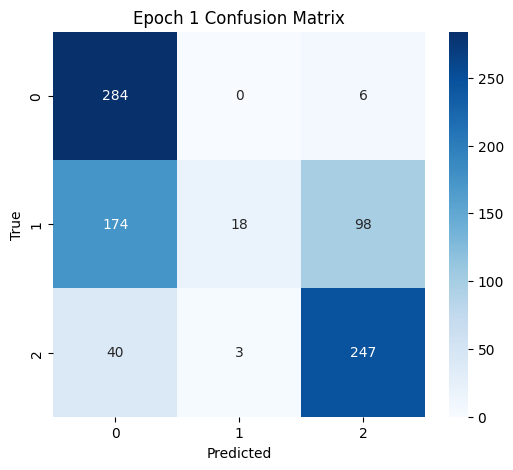


=== Evaluating QLoRA epoch 2 ===
🔄 Loading QLoRA model from: ./qlora-sentiment-ep2


The tokenizer you are loading from './qlora-sentiment-ep2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


✅ Model and tokenizer loaded.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Accuracy (epoch 2): 0.6862


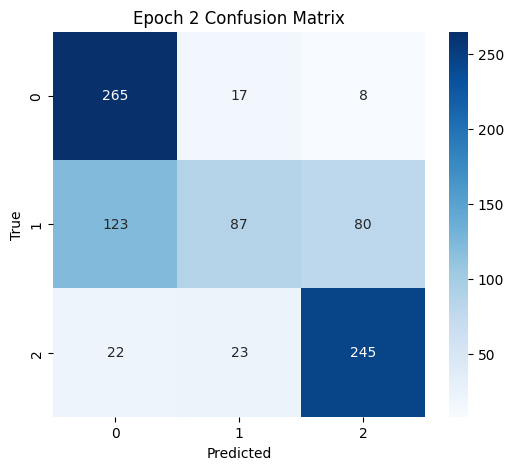


=== Evaluating QLoRA epoch 3 ===
🔄 Loading QLoRA model from: ./qlora-sentiment-ep3


The tokenizer you are loading from './qlora-sentiment-ep3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


✅ Model and tokenizer loaded.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Accuracy (epoch 3): 0.6874


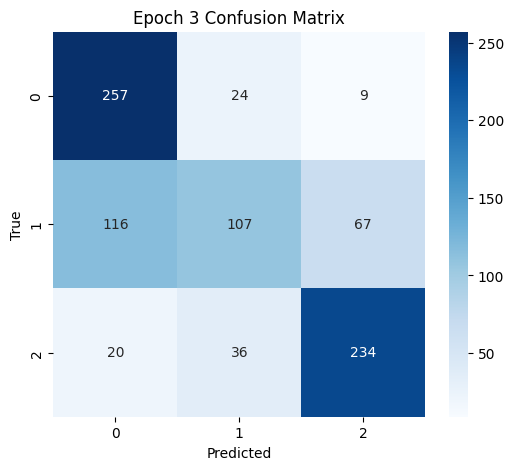


=== Evaluating QLoRA epoch 5 ===
🔄 Loading QLoRA model from: ./qlora-sentiment-ep5


The tokenizer you are loading from './qlora-sentiment-ep5' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


✅ Model and tokenizer loaded.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Accuracy (epoch 5): 0.6931


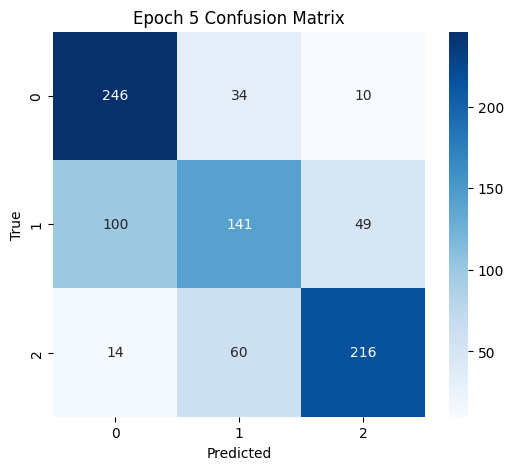


=== Evaluating QLoRA epoch 7 ===
🔄 Loading QLoRA model from: ./qlora-sentiment-ep7


The tokenizer you are loading from './qlora-sentiment-ep7' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


✅ Model and tokenizer loaded.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Accuracy (epoch 7): 0.6920


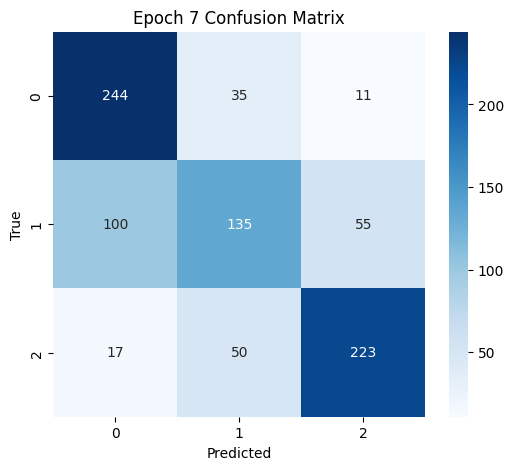

In [24]:
#Initialize result containers
results = {}
dfs = {}

EPOCHS = [1, 2, 3, 5, 7]

for ep in EPOCHS:
    model_path = f"./qlora-sentiment-ep{ep}"
    print(f"\n=== Evaluating QLoRA epoch {ep} ===")

    predict_fn = make_predict_qlora(model_path)
    gold, preds, df = evaluate_model_predictions(predict_fn)

    acc = accuracy_score(gold, preds)
    results[ep] = acc
    dfs[ep] = df

    print(f"Accuracy (epoch {ep}): {acc:.4f}")
    plot_confusion_matrix(gold, preds, title=f"Epoch {ep} Confusion Matrix")



In [30]:
import random
import pandas as pd

# Choose which epoch’s model you want to test
model_path = "./qlora-sentiment-ep3"   # ← change this if needed

predict_fn = make_predict_qlora(model_path)

# Pick 10 random samples from the test set
samples = random.sample(list(dataset["test"]), 10)

rows = []
for row in samples:
    text = row["text"]
    true_label = row["label"]
    pred_label = label2id[predict_fn(text)]

    rows.append({
        "tweet": text,
        "true_label": true_label,
        "predicted_label": pred_label
    })

df_samples = pd.DataFrame(rows)
df_samples


🔄 Loading QLoRA model from: ./qlora-sentiment-ep3


The tokenizer you are loading from './qlora-sentiment-ep3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


✅ Model and tokenizer loaded.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

,tweet,true_label,predicted_label
0,@user How stupid was that woman not to realize...,0,0
1,@user @user @user I have yet to hear of any he...,0,0
2,1) re-imposition of the death penalty2) loweri...,0,0
3,#Angular is completely lost. They keep throwin...,0,0
4,This is huge - #Microsoft joins the #LinuxFoun...,2,2
5,Embargo on Cuba not working. #FreeCuba. #MAGA,0,0
6,@user for al the crying you do about how middl...,0,0
7,@user Your President Elect has called for dron...,0,0
8,Cristiano Ronaldo and Jose Mourinho suspected ...,0,0
9,129 days until the release of Persona 5,1,2


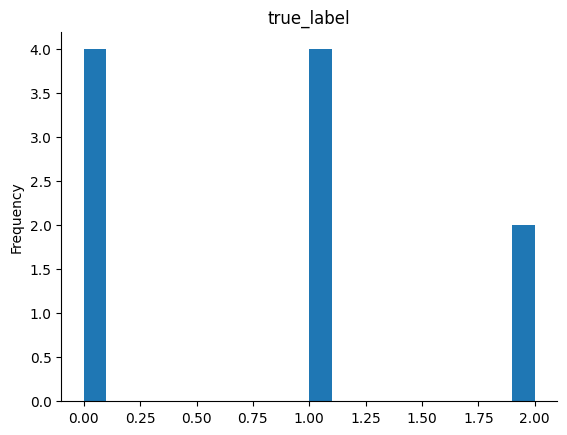

In [26]:
from matplotlib import pyplot as plt
df_samples['true_label'].plot(kind='hist', bins=20, title='true_label')
plt.gca().spines[['top', 'right',]].set_visible(False)

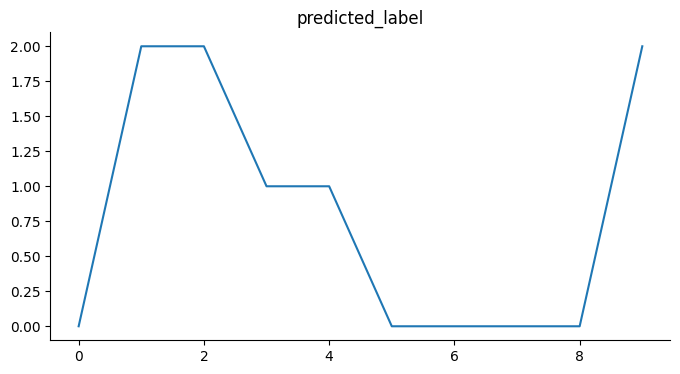

In [27]:
from matplotlib import pyplot as plt
df_samples['predicted_label'].plot(kind='line', figsize=(8, 4), title='predicted_label')
plt.gca().spines[['top', 'right']].set_visible(False)

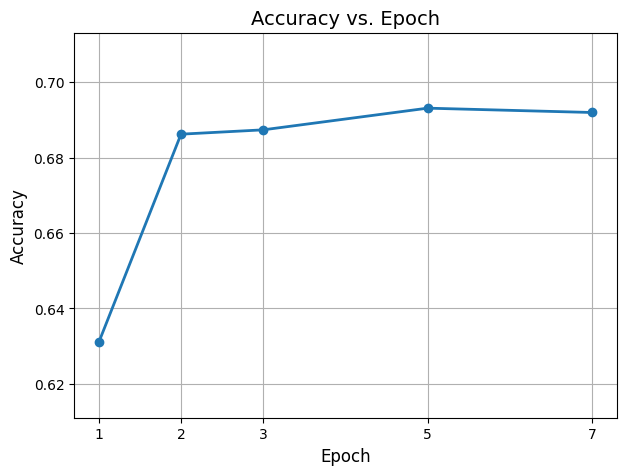

In [31]:
import matplotlib.pyplot as plt

# results should look like: {1: 0.63, 2: 0.68, 3: 0.70, 5: 0.69, 7: 0.71}
# (Your actual values from evaluation)

epochs = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(7,5))
plt.plot(epochs, accuracies, marker="o", linewidth=2)
plt.title("Accuracy vs. Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True)
plt.xticks(epochs)
plt.ylim(min(accuracies) - 0.02, max(accuracies) + 0.02)
plt.show()
